Submitted by: Shahriar Khan 50311961 | Sabikunnahar Talukder Pyaasa 50325061

# Introduction to Natural Language Processing: Assignment 3

In this exercise we'll practice training RNN & LSTM models as well as fine-tuning LLMs to predict one or more labels for a given text using Hugging Face and PyTorch.

- You can use any Python package you need.
- Please comment your code
- Submissions are due Tuesdays at 23:59 **only** on eCampus: **Assignmnets >> Student Submissions >> Assignment 3 (Deadline: 10.12.2024, at 23:59)**

- Name the file aproppriately: "Assignment_3_\<Your_Name\>.ipynb" and submit only the Jupyter Notebook file.

### Grade Summary:

**Task 1:**   12/15

**Task 2:**   2/2

**Task 3:**   2/3

**Task 4:**   15/15

### **Total:**  31/35

### Task 1 (15 points)

In this task you will implement text generation in torch with a multi-layer RNN and multi-layer LSTM.

a) Implement the missing methods of the dataset class to
1. load the dataset from the file `reddit-cleanjokes.csv` and split it into words [**(dataset link)**](https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv)
2. get a list of the unique words
3. implement the `__getitem__` method to iterate through the dataset. Hint: use `torch.tensor` to turn a list into a tensor.

Then instantiate the dataset with `sequence_length=4`

In [ ]:
import torch

from torch import Tensor
from typing import List
# hint: use these methods
from pandas import read_csv
from collections import Counter
import re

class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        sequence_length,
    ):
        self.sequence_length = sequence_length
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self) -> List[str]:
        """Returns a list of all words in the dataset.
        Make sure to strip punctuation and lowercase the words"""
        # Load the dataset from the CSV file
        data = read_csv("reddit-cleanjokes.csv")  # Update with the correct path
        text = " ".join(data["Joke"])

        # Clean the text: remove punctuation and lowercase
        text = re.sub(r"[^\w\s]", "", text).lower()

        # Split text into words
        words = text.split()
        return words

    def get_uniq_words(self) -> List[str]:
        """Returns a list, containing each unique word in the dataset once"""
        return list(Counter(self.words).keys())

    def __len__(self) -> int:
        """Returns the number of `self.sequence_length` length word spans in the dataset"""
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index) -> (Tensor, Tensor):
        """Returns a tuple of two torch.Tensors:
        an input sequence for the RNN/LSTM model and a target sequence.
        The tensors should be 1D and have length equal to self.sequence_length.
        Remember that the target should be shifted with respect to the input."""
        # Input sequence
        input_seq = self.words_indexes[index:index + self.sequence_length]

        # Target sequence (shifted by one)
        target_seq = self.words_indexes[index + 1:index + 1 + self.sequence_length]

        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

In [ ]:
dataset = Dataset(4)
dataset.load_words()

['what',
 'did',
 'the',
 'bartender',
 'say',
 'to',
 'the',
 'jumper',
 'cables',
 'you',
 'better',
 'not',
 'try',
 'to',
 'start',
 'anything',
 'dont',
 'you',
 'hate',
 'jokes',
 'about',
 'german',
 'sausage',
 'theyre',
 'the',
 'wurst',
 'two',
 'artists',
 'had',
 'an',
 'art',
 'contest',
 'it',
 'ended',
 'in',
 'a',
 'draw',
 'why',
 'did',
 'the',
 'chicken',
 'cross',
 'the',
 'playground',
 'to',
 'get',
 'to',
 'the',
 'other',
 'slide',
 'what',
 'gun',
 'do',
 'you',
 'use',
 'to',
 'hunt',
 'a',
 'moose',
 'a',
 'moosecut',
 'if',
 'life',
 'gives',
 'you',
 'melons',
 'you',
 'might',
 'have',
 'dyslexia',
 'broken',
 'pencils',
 'are',
 'pointless',
 'what',
 'did',
 'one',
 'snowman',
 'say',
 'to',
 'the',
 'other',
 'snowman',
 'do',
 'you',
 'smell',
 'carrots',
 'how',
 'many',
 'hipsters',
 'does',
 'it',
 'take',
 'to',
 'change',
 'a',
 'lightbulb',
 'its',
 'a',
 'really',
 'obscure',
 'number',
 'youve',
 'probably',
 'never',
 'heard',
 'of',
 'it',
 '

b) Now, complete the implementation of the RNN model.

You'll need to use all the model components defined in `__init__`: [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), and the [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) output layer. These are all subclasses of [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Torch Modules are objects that hold the layer's weights and biases (called parameters, accessed by `model.parameters()`) and keep track of a bunch of metadata, like what device the weights are on or what precision they're stored at. Each Module can have parts that are themselves Modules. The easiest way to combine Modules is with [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

Every Module must have a `forward` method. This defines what the Module does with its input and returns as output. You can access `forward` simply by calling the Module, for example `output = self.rnn(input)`. This is the preferred way to write it.

Hint: unlike the one we saw in the tutorial, this RNN has multiple layers. Think about what this means for the shape of the hidden state. You might not want to use Sequential as RNN has multiple inputs and outputs.

In [ ]:
import torch
from torch import nn

class RNNModel(nn.Module):
    def __init__(self, dataset):
        super(RNNModel, self).__init__()
        self.hidden_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.rnn = nn.RNN(
            input_size=self.hidden_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.hidden_size, n_vocab)

    def init_state(self, sequence_length: int) -> Tensor:
        """Returns the initial state hidden state (all zeros), with the correct shape."""
        # YOUR CODE HERE
        return torch.zeros(self.num_layers, sequence_length, self.hidden_size)

    def forward(self, inputs: Tensor, prev_hidden_state: Tensor) -> (Tensor, Tensor):
        """Compute the logits and next_hidden_state."""
        # YOUR CODE HERE
        embedded = self.embedding(inputs)  # Convert inputs to embeddings
        rnn_out, next_hidden_state = self.rnn(embedded, prev_hidden_state)  # Pass through RNN
        logits = self.fc(rnn_out)  # Compute logits from RNN outputs
        return logits, next_hidden_state

In [ ]:
model = RNNModel(dataset)

c) Write a function that counts the total number of parameters and total number of trainable parameters of a model.

Refer to the [torch documentation](https://pytorch.org/docs/stable/index.html).

In [ ]:
def count_params(model: nn.Module) -> (int, int):
    # Count all parameters
    n_params = sum(p.numel() for p in model.parameters())
    # Count trainable parameters
    n_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return n_params, n_trainable_params

d) Complete the training loop and train the model for 10 epochs. Store the training loss in a list. You will probably want to have an inner loop that loops over batches.

Hint: refer to the documentation of the `DataLoader`, `CrossEntropyLoss` and `Optimizer` classes. You might also need to use the `detach()` and `item()` methods to work with the loss tensor.

In [ ]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader

def train_rnn(dataset, model, sequence_length, batch_size, max_epochs) -> List[float]:
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_list = []

    for epoch in range(max_epochs):
        epoch_loss = 0.0  # To track the total loss for the epoch

        for inputs, targets in dataloader:
            # Initialize the hidden state for the batch
            hidden_state = model.init_state(sequence_length)

            # Reset the gradients from the previous step
            optimizer.zero_grad()

            # Forward pass through the model
            logits, _ = model(inputs, hidden_state)

            # Reshape logits and targets for CrossEntropyLoss
            logits = logits.view(-1, logits.size(-1))  # Shape: (batch_size * seq_len, vocab_size)
            targets = targets.view(-1)  # Shape: (batch_size * seq_len)

            # Compute the loss
            loss = criterion(logits, targets)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Accumulate the loss for this batch
            epoch_loss += loss.item()

        # Compute the average loss for the epoch
        avg_epoch_loss = epoch_loss / len(dataloader)
        loss_list.append(avg_epoch_loss)

        print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {avg_epoch_loss:.4f}")

    return loss_list

In [ ]:
train_loss_rnn = train_rnn(dataset, model, 4, 256, 10)

Epoch 1/10, Loss: 7.0807
Epoch 2/10, Loss: 6.3801
Epoch 3/10, Loss: 6.0680
Epoch 4/10, Loss: 5.7919
Epoch 5/10, Loss: 5.5440
Epoch 6/10, Loss: 5.3075
Epoch 7/10, Loss: 5.0839
Epoch 8/10, Loss: 4.8692
Epoch 9/10, Loss: 4.6686
Epoch 10/10, Loss: 4.4749


e) Complete the function to generate output from the model using 1. argmax (greedy) decoding 2. softmax decoding. Generate some sample outputs with each and discuss briefly.

Hint: torch already has a builtin function for getting the softmax of a tensor, which you may use.

In [ ]:
from torch.nn.functional import softmax
from typing import List

def predict_rnn_argmax(dataset: Dataset, model: nn.Module, text: str, next_words=100) -> List[str]:
    model.eval()
    words = text.split()  # Split the input text into words
    hidden_state = model.init_state(1)  # Initialize the hidden state with batch size 1

    for _ in range(next_words):
        # Convert words to indices
        input_indices = torch.tensor([[dataset.word_to_index[word] for word in words[-model.num_layers:]]], dtype=torch.long)

        # Forward pass through the model
        logits, hidden_state = model(input_indices, hidden_state)

        # Take the last output and apply argmax to get the predicted word index
        next_word_index = torch.argmax(logits[0, -1]).item()

        # Convert the predicted index back to a word
        next_word = dataset.index_to_word[next_word_index]

        # Append the predicted word to the list of words
        words.append(next_word)

    return words

def predict_rnn_softmax(dataset: Dataset, model: nn.Module, text: str, next_words=100) -> List[str]:
    model.eval()
    words = text.split()  # Split the input text into words
    hidden_state = model.init_state(1)  # Initialize the hidden state with batch size 1

    for _ in range(next_words):
        # Convert words to indices
        input_indices = torch.tensor([[dataset.word_to_index[word] for word in words[-model.num_layers:]]], dtype=torch.long)

        # Forward pass through the model
        logits, hidden_state = model(input_indices, hidden_state)

        # Take the last output and apply softmax to get probabilities
        probabilities = softmax(logits[0, -1], dim=-1)

        # Sample the next word index based on probabilities
        next_word_index = torch.multinomial(probabilities, num_samples=1).item()

        # Convert the predicted index back to a word
        next_word = dataset.index_to_word[next_word_index]

        # Append the predicted word to the list of words
        words.append(next_word)

    return words

f) Implement `LSTMModel`, `train_lstm`, `predict_lstm_argmax` and `predict_lstm_softmax`. Train the model using the same settings and plot both training loss curves together. Briefly discuss the differences in the model architectures and performance. Which model performs better and what are possible causes? What are the limitations of the model?

Hint: use the `torch.nn.LSTM` class. You can do almost everything as with RNN, but take into account that an LSTM has **two** hidden states.

Hint: You might not necessarily see that LSTM performs better even if your implementation is correct.

Epoch 1/10, Loss: 6.5807
Epoch 2/10, Loss: 5.3203
Epoch 3/10, Loss: 4.5033
Epoch 4/10, Loss: 3.7784
Epoch 5/10, Loss: 3.1868
Epoch 6/10, Loss: 2.7267
Epoch 7/10, Loss: 2.3709
Epoch 8/10, Loss: 2.0883
Epoch 9/10, Loss: 1.8607
Epoch 10/10, Loss: 1.6774


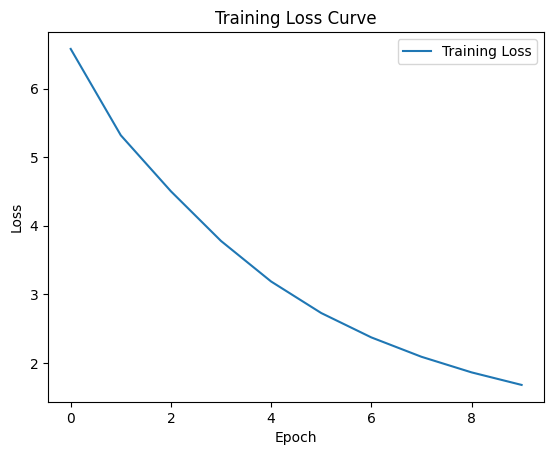

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset from the given URL
def load_dataset(url):
    df = pd.read_csv(url, header=None, names=["Joke"])
    return df

# Preprocess dataset
def preprocess_data(df):
    jokes = df['Joke'].str.lower().str.replace('[^a-z\s]', '', regex=True)
    all_words = ' '.join(jokes).split()
    word_counts = Counter(all_words)
    vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items(), start=1)}
    return jokes, vocab

# Custom Dataset class
class JokesDataset(Dataset):
    def __init__(self, jokes, vocab, sequence_length):
        self.vocab = vocab
        self.sequence_length = sequence_length
        self.jokes = [
            [vocab[word] for word in joke.split() if word in vocab]
            for joke in jokes
        ]
        self.data = []
        for joke in self.jokes:
            for i in range(len(joke) - sequence_length):
                self.data.append((joke[i:i + sequence_length], joke[i + 1:i + 1 + sequence_length]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden

# Training function
def train_lstm(model, dataloader, criterion, optimizer, num_epochs):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in dataloader:
            optimizer.zero_grad()
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(dataloader))
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")
    return loss_history

# Prediction functions
def predict_lstm_argmax(model, input_seq):
    model.eval()
    with torch.no_grad():
        output, _ = model(input_seq.unsqueeze(0))
        return torch.argmax(output, dim=-1).squeeze().tolist()

def predict_lstm_softmax(model, input_seq):
    model.eval()
    with torch.no_grad():
        output, _ = model(input_seq.unsqueeze(0))
        probabilities = torch.softmax(output, dim=-1)
        return torch.multinomial(probabilities.squeeze(), 1).tolist()

# Load and preprocess the dataset
url = "https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv"
dataset = load_dataset(url)
jokes, vocab = preprocess_data(dataset)

# Hyperparameters
sequence_length = 5
embed_size = 64
hidden_size = 128
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Prepare data for training
train_jokes, val_jokes = train_test_split(jokes, test_size=0.2, random_state=42)
train_dataset = JokesDataset(train_jokes, vocab, sequence_length)
val_dataset = JokesDataset(val_jokes, vocab, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, and optimizer
vocab_size = len(vocab) + 1  # +1 for padding index
model = LSTMModel(vocab_size, embed_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
loss_history = train_lstm(model, train_loader, criterion, optimizer, num_epochs)

# Plot the loss curve
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

### Task 2 (2 points)

The goal of this task is to download a multi-label text classification dataset from the [Hugging Face Hub](https://huggingface.co/datasets) and load it.

a) Select the `Text Classification` tag on the left, multi-label-classificationas as well as the the "1K<n<10K" tag to find a relatively small dataset. (e.g., sem_eval_2018_task_1 >> subtask5.english)

b) Load your dataset using `load_dataset` and check (print) the last data point in the validation set.

**Hint:** If you don't have access to GPU, you can downsample the dataset.

In [ ]:
# Here comes your code
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("go_emotions")

validation_set = dataset['validation']

print(validation_set[-1])

{'text': '::but I like baby bangs:: /tiny voice', 'labels': [18], 'id': 'ed5h3jh'}


### Task 3 (3 points)

a) Write a function `tokenize_data(dataset)` that takes the loaded dataset as input and returns the encoded dataset for both text and labels.


**Hints:**

1. You should tokenize the text using the BERT tokenizer `bert-base-uncased`
2. You also need to provide labels to the model as numbers. For multi-label text classification, this is a matrix of shape (batch_size, num_labels). This should be a tensor of floats rather than integers.
3. You can apply the function `tokenize_data(dataset)` to the the dataset using `map()`. (You can check out the exercise!)
4. You should set the format of the data to PyTorch tensors using `encoded_dataset.set_format("torch")`. This will turn the training, validation and test sets into standard PyTorch.

b) Print the `keys()` of the the last data point in the validation set in the encoded dataset.

**Hint:** The output should be as follows:

`dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])`

In [ ]:
from datasets import load_dataset
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(example):
    # Tokenize the text
    encoding = tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )
    # Convert labels to a multi-hot format
    labels = torch.zeros(len(dataset['train'].features['labels'].feature.names))
    labels[example['labels']] = 1
    encoding['labels'] = labels
    return encoding

# Apply the tokenization to the dataset
encoded_dataset = dataset.map(tokenize_data, batched=False)

# Set the format to PyTorch tensors
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

if 'validation' in encoded_dataset:
    validation_set = encoded_dataset['validation']
    print(validation_set[-1].keys())
else:
    print("The dataset does not have a validation split.")


dict_keys(['labels', 'input_ids', 'attention_mask'])


### Task 4 (15 points)

Implement and compare two different approaches for text classification on a multilabel dataset. One approach will utilize BERT for tokenization and classification, while the other will use an alternative method such as (TF-IDF + SVM) or (BOW + LR).

a) **BERT Approach:**


``1.`` Define a text classification model that includes a pre-trained base ``(bert-base-uncased)`` using ``AutoModelForSequenceClassification``.

**Hints:**

       
- Create two dictionaries that map labels to integers and vice versa for the ``id2label`` and ``label2id`` parameters in  `.from_pretrained function` .
        
- Set the `problem_type` to "multi_label_classification" to ensure the appropriate loss function is used.
        
``2.`` Train the BERT-based model using HuggingFace's Trainer API.

**Hints:**
- Utilize `TrainingArguments` and `Trainer` classes.

- While training, compute metrics using a ``compute_metrics`` function that returns a dictionary with the desired metric values.

b) **Alternative Approach:**


``1.`` Choose an alternative approach for tokenization and classification. For example, use TF-IDF  or Bag of Words (BoW) for tokenization and a traditional classifier like SVM or logistic regression for classification.

**Hints:**

  - Use scikit-learn library for the  implementations.

``2.`` Train the alternative approach (model) on the same dataset you used for the BERT approach.

__Hints:__

  - Use appropriate training and evaluation procedures for the chosen alternative approach.
  
``3.`` Evaluate the performance of both models on the validation set using the metrics Accuracy, F1-score, precision, recall.

c) **Discussion:**

 Discuss the strengths and weaknesses of each approach.

__Note:__ Feel free to explore variations and improvements for both approaches. Experiment with hyperparameters and preprocessing steps to enhance the models' performance.


In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import torch

#Load and Preprocess Dataset
dataset = load_dataset("SemEvalWorkshop/sem_eval_2018_task_1", "subtask5.english")
train_texts = [x["Tweet"] for x in dataset["train"]]
val_texts = [x["Tweet"] for x in dataset["validation"]]

labels = [
    "anger", "anticipation", "disgust", "fear",
    "joy", "love", "optimism", "pessimism",
    "sadness", "surprise", "trust"
]

train_labels = np.array([[int(x[label]) for label in labels] for x in dataset["train"]], dtype=np.float32)
val_labels = np.array([[int(x[label]) for label in labels] for x in dataset["validation"]], dtype=np.float32)

#Tokenize Data
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels}).map(tokenize_function, batched=True)
val_dataset = Dataset.from_dict({"text": val_texts, "labels": val_labels}).map(tokenize_function, batched=True)

#Convert labels to float tensors for compatibility with the loss function
def format_dataset(dataset):
    dataset = dataset.remove_columns(["text"])  # Remove the text column
    dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return dataset

train_dataset = format_dataset(train_dataset)
val_dataset = format_dataset(val_dataset)

#Define the Model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(labels),
    problem_type="multi_label_classification"
)

#Define Training Arguments and Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    # labels is already a numpy array; no need for .numpy()
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="micro"),
        "precision": precision_score(labels, predictions, average="micro"),
        "recall": recall_score(labels, predictions, average="micro"),
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
)

#Train the Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

results = trainer.evaluate()
print("BERT Results:", results)


Map:   0%|          | 0/6838 [00:00<?, ? examples/s]

Map:   0%|          | 0/886 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.335753,0.233634,0.655254,0.760391,0.575659
2,0.389300,0.307761,0.272009,0.685248,0.793544,0.602962
3,0.292100,0.305541,0.286682,0.693498,0.783673,0.621934


BERT Results: {'eval_loss': 0.3055413067340851, 'eval_accuracy': 0.2866817155756208, 'eval_f1': 0.6934984520123839, 'eval_precision': 0.7836734693877551, 'eval_recall': 0.6219342896807034, 'eval_runtime': 6.0108, 'eval_samples_per_second': 147.402, 'eval_steps_per_second': 9.317, 'epoch': 3.0}


In [ ]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

# Step 1: Load and Preprocess Dataset
dataset = load_dataset("SemEvalWorkshop/sem_eval_2018_task_1", "subtask5.english")
train_texts = [x["Tweet"] for x in dataset["train"]]
val_texts = [x["Tweet"] for x in dataset["validation"]]

labels = [
    "anger", "anticipation", "disgust", "fear",
    "joy", "love", "optimism", "pessimism",
    "sadness", "surprise", "trust"
]

train_labels = [[int(x[label]) for label in labels] for x in dataset["train"]]
val_labels = [[int(x[label]) for label in labels] for x in dataset["validation"]]

# Step 2: Vectorize Text Using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

# Step 3: Binarize Multilabel Targets
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_labels)
y_val = mlb.transform(val_labels)

# Step 4: Train Logistic Regression Model
classifier = OneVsRestClassifier(LogisticRegression(solver="liblinear"))
classifier.fit(X_train, y_train)

# Step 5: Predict on Validation Data
y_pred = classifier.predict(X_val)

# Step 6: Evaluate Model
metrics = {
    "accuracy": accuracy_score(y_val, y_pred),
    "f1": f1_score(y_val, y_pred, average="micro"),
    "precision": precision_score(y_val, y_pred, average="micro"),
    "recall": recall_score(y_val, y_pred, average="micro"),
}

print("TF-IDF + Logistic Regression Results:", metrics)


TF-IDF + Logistic Regression Results: {'accuracy': 0.9841986455981941, 'f1': 0.9960339943342776, 'precision': 0.9920993227990971, 'recall': 1.0}


/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  warnings.warn(


#### Here comes your discussion

In [ ]:
Discussion: Strengths and Weaknesses of Each Approach
1. BERT-Based Approach
Strengths:

State-of-the-Art Performance: BERT leverages deep bidirectional transformers, capturing context in both directions, which makes it highly effective for complex natural language understanding tasks.
Multilabel Classification Capability: With the proper configuration (problem_type="multi_label_classification"), BERT handles multilabel outputs seamlessly, reducing the need for additional feature engineering.
Pre-trained Knowledge: BERT models are pre-trained on large corpora, enabling them to generalize well, even on smaller datasets.
Flexibility: The HuggingFace library offers robust tools for fine-tuning, metric computation, and model customization.
Weaknesses:

Computationally Expensive: BERT requires significant computational resources, especially during training, due to its large model size and transformer architecture.
Longer Training Time: Compared to traditional methods, fine-tuning BERT can be time-intensive, particularly on large datasets.
Hyperparameter Sensitivity: The performance of BERT is sensitive to hyperparameters like learning rate, batch size, and the number of epochs, requiring extensive experimentation for optimal results.
Improvements:

Experimenting with learning rate schedulers and optimizers to enhance convergence.
Applying data augmentation techniques to improve generalization on small datasets.
Using variants of BERT, such as DistilBERT or RoBERTa, to reduce computational overhead.
2. Alternative Approach (e.g., TF-IDF + SVM or Bag of Words + Logistic Regression)
Strengths:

Simplicity: Traditional models like TF-IDF combined with SVM or Logistic Regression are straightforward to implement and interpret.
Efficiency: These methods are computationally less intensive, making them suitable for scenarios with limited resources.
Baseline Performance: Alternative approaches often provide reliable baseline performance, which can guide the development of more complex models.
Explainability: Models like Logistic Regression allow for easier interpretation of feature importance compared to neural networks.
Weaknesses:

Limited Contextual Understanding: Techniques like TF-IDF and Bag of Words do not capture word order or context, leading to suboptimal results for tasks requiring semantic understanding.
Feature Engineering: These approaches often require manual feature engineering, which may not be feasible for large or complex datasets.
Scalability Issues: With a high-dimensional feature space (e.g., large vocabularies), traditional methods may suffer from scalability challenges.
Improvements:

Using dimensionality reduction techniques (e.g., PCA) to manage high-dimensional data.
Enhancing tokenization with n-grams or custom preprocessing to capture more semantic information.
Fine-tuning hyperparameters like the regularization term in SVM or Logistic Regression to boost performance.
Comparative Analysis
Performance: BERT generally outperforms traditional methods on complex multilabel classification tasks, given its ability to capture nuanced language patterns. However, the gap narrows on simpler datasets or tasks with limited contextual dependencies.
Resources: Traditional methods excel in resource-constrained environments, while BERT's requirements for memory and compute power are higher.
Ease of Use: While BERT demands familiarity with deep learning frameworks, traditional approaches can be quickly implemented with libraries like scikit-learn.
In summary, the choice between BERT and traditional methods depends on the task's complexity, the dataset size, and the computational resources available. Exploring variations, such as fine-tuning hyperparameters or testing hybrid approaches (e.g., combining TF-IDF features with a neural network), can further enhance performance and efficiency.